In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from matplotlib import rcParams
from collections import defaultdict, Counter
from konlpy.tag import Okt
from datetime import datetime
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/opt/anaconda3/envs/ESTsoft_TP_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 게시글에서 특정 키워드(예: 정치인, 정책)의 언급 빈도(언급량)를 추출하여 '버즈 차트'를 생성

In [3]:
# ───────────── 설정 ─────────────
# rcParams['font.family'] = 'NanumSquare'
rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

DATA_DIR = "../01_데이터수집/data/제21대_대선_테마주/"
PAXNET_PATH = "../01_데이터수집/비정형데이터/faxnet_21/팍스넷_21대_대선_테마주_크롤링_20250627.csv"
NAVER_PATH = "../01_데이터수집/비정형데이터/stock_community/output/csv/제21대_대선_테마주/"

FIXED_START = datetime(2025, 5, 3)
FIXED_END = datetime(2025, 6, 10)

In [4]:
# ───────────── 데이터 로딩 ─────────────

####################### 팍스넷 데이터 ##################################
paxnet_df = pd.read_csv(PAXNET_PATH)
paxnet_df["날짜"] = pd.to_datetime(paxnet_df["날짜"])
#####################################################################



####################### 네이버 종토방 데이터 #############################
csv_files = [f for f in os.listdir(NAVER_PATH) if f.endswith(".csv")]   # 경로 내 csv 파일 목록 가져오기

dataframes = [] # concat 저장용

# 각 CSV 파일 읽어서 리스트에 추가
for file in csv_files:
    file_path = os.path.join(NAVER_PATH, file)
    try:
        df = pd.read_csv(file_path)
        df['filename'] = file  # 어떤 파일에서 왔는지 표시
        dataframes.append(df)
    except Exception as e:
        print(f"파일 읽기 오류: {file_path} → {e}")

naver_df = pd.concat(dataframes, ignore_index=True) # concat
naver_df['article_date'] = pd.to_datetime(naver_df['article_date'])
#####################################################################

okt = Okt()  # 형태소 분석기 인스턴스 생성

In [5]:
# ───────────── 데이터 전처리 ─────────────
naver_selected_df = naver_df[["stock_name", "article_date", "article_title", "article_content"]].copy()
naver_selected_df.rename(columns={
    "stock_name": "종목명",
    "article_date": "날짜",
    "article_title": "제목",
    "article_content": "내용"
}, inplace=True)

paxnet_selected_df = paxnet_df[['종목명', '날짜', '제목', '내용']].copy()

stock_df = pd.concat([naver_selected_df, paxnet_selected_df], ignore_index=True)    # 데이터 병합
stock_df.sort_values(by='날짜', inplace=True)   # datetime 순서로 정렬

In [6]:
# ───────────── 후보별 테마주 데이터 분리 ─────────────
jae_keywords = ["코나아이", "웹케시", "상지건설", "오리엔트바이오", "포바이포"]     # 이재명 후보 테마주
moon_keywords = ["평화홀딩스", "평화산업", "대영포장", "한솔홈데코", "윌비스"]      # 김문수 후보 테마주
jun_keywords = ["삼보산업", "넥스트아이", "태영건설우"]                           # 이준석 후보 테마주

# 이재명 후보 테마주
jae_df = stock_df[stock_df["종목명"].isin(jae_keywords)].copy()
jae_df["후보"] = "이재명"

# 김문수 후보 테마주
moon_df = stock_df[stock_df["종목명"].isin(moon_keywords)].copy()
moon_df["후보"] = "이재명"

# 이준석 후보 테마주
jun_df = stock_df[stock_df["종목명"].isin(jun_keywords)].copy()
jun_df["후보"] = "이재명"

In [7]:
# ─────────────────────────────────────────────
# MyKeywordExtractor: 형태소 + BERT 기반 키워드 추출기
# ─────────────────────────────────────────────
class MyKeywordExtractor:
    def __init__(self, model_name="klue/bert-base", device=None, min_freq=2):
        self.okt = Okt()
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.device = device or ("mps" if torch.backends.mps.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()
        self.min_freq = min_freq

    def get_cls_embedding(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] 벡터
        return cls_embedding.cpu().numpy()

    def get_token_embedding(self, word):
        inputs = self.tokenizer(word, return_tensors="pt", truncation=True, max_length=20)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
        token_embeds = outputs.last_hidden_state.mean(dim=1)  # mean pooling
        return token_embeds.cpu().numpy()

    def extract_keywords(self, text_list, top_k=15):
        noun_counter = Counter()
        for text in text_list:
            if not isinstance(text, str): continue
            nouns = self.okt.nouns(text)
            noun_counter.update(nouns)

        candidates = [word for word, count in noun_counter.items() if count >= self.min_freq]
        if not candidates:
            return []

        full_text = " ".join(text_list)
        doc_embedding = self.get_cls_embedding(full_text)

        scored_words = []
        for word in candidates:
            token_embed = self.get_token_embedding(word)
            similarity = cosine_similarity(doc_embedding, token_embed)[0][0]
            scored_words.append((word, similarity))

        scored_words.sort(key=lambda x: x[1], reverse=True)
        return [word for word, _ in scored_words[:top_k]]

# ─────────────────────────────────────────────
# 후보·종목별 키워드를 포함한 데이터프레임 생성
# ─────────────────────────────────────────────
def make_keyword(
    후보명,
    df,
    종목명="종목명",
    제목="제목",
    내용="내용",
    top_k=15,
    min_freq=2
):
    extractor = MyKeywordExtractor(min_freq=min_freq)
    result_rows = []

    grouped_by_stock = df.groupby(종목명)

    for 종목, group in tqdm(grouped_by_stock, desc=f"{후보명} 종목별 키워드 추출"):
        title_list = group[제목].dropna().tolist()
        content_list = group[내용].dropna().tolist()
        text_list = title_list + content_list

        if not text_list:
            continue

        # 형태소 분석 후 빈도 계산
        noun_counter = Counter()
        for text in text_list:
            if not isinstance(text, str): continue
            nouns = extractor.okt.nouns(text)
            noun_counter.update(nouns)

        # BERT 기반으로 의미 있는 키워드만 선별
        candidates = {noun: count for noun, count in noun_counter.items() if count >= min_freq}
        if not candidates:
            continue

        doc_embedding = extractor.get_cls_embedding(" ".join(text_list))
        scored_keywords = []

        for word, count in candidates.items():
            token_embed = extractor.get_token_embedding(word)
            similarity = cosine_similarity(doc_embedding, token_embed)[0][0]
            scored_keywords.append((word, similarity, count))

        # 상위 top_k 개수만 선택
        scored_keywords.sort(key=lambda x: x[1], reverse=True)
        top_keywords = scored_keywords[:top_k]

        # 형태: {'키워드': 등장횟수}
        keyword_dict = {word: freq for word, _, freq in top_keywords}

        result_rows.append({
            "후보": 후보명,
            "종목명": 종목,
            "키워드": keyword_dict
        })

    return pd.DataFrame(result_rows)

In [8]:
# 후보별로 따로 실행
jae_keywords_df = make_keyword("이재명", jae_df, top_k=50, min_freq=2)
moon_keywords_df = make_keyword("김문수", moon_df, top_k=50, min_freq=2)
jun_keywords_df = make_keyword("이준석", jun_df, top_k=50, min_freq=2)

이준석 종목별 키워드 추출: 100%|██████████| 3/3 [01:10<00:00, 23.52s/it]


In [ ]:
# 통합
final_df = pd.concat([jae_keywords_df, moon_keywords_df, jun_keywords_df], ignore_index=True)

os.makedirs("data", exist_ok=True)
# final_df.to_csv("data/제21대_대선후보_종목별_키워드.csv", index=False)

In [10]:
final_df

,후보,종목명,키워드
0,이재명,상지건설,"{'이재명': 1823, '대단원': 2, '이재용': 2, '뉴스떳': 2, '패..."
1,이재명,오리엔트바이오,"{'급락': 5, '탄핵': 39, '공매도': 8, '조갑제닷컴': 2, '사퇴'..."
2,이재명,웹케시,"{'급락': 18, '급등': 52, '공매도': 20, '종목': 91, '거래량..."
3,이재명,코나아이,"{'폭주기관차': 3, '답글': 201, '게시판글': 2, '신뢰수준': 3, ..."
4,이재명,포바이포,"{'이재명': 698, '이명박': 13, '종북': 19, '적폐': 3, '정신..."
5,김문수,대영포장,"{'공매도': 44, '급락': 10, '불참': 7, '윤핵관넘들': 4, '이명..."
6,김문수,윌비스,"{'급락': 4, '종목': 15, '주식시장': 2, '액면가': 3, '급등':..."
7,김문수,평화산업,"{'급락': 13, '집값땅값': 2, '급등': 40, '주식시장': 5, '하락..."
8,김문수,평화홀딩스,"{'물량정리': 2, '이나라': 33, '물량좀': 4, '요약': 20, '물량..."
9,김문수,한솔홈데코,"{'이재명': 32, '도대체': 3, '나락갑니': 2, '고발장': 2, '진흙..."


In [11]:
class BuzzChartGenerator:
    def __init__(self, keyword_df: pd.DataFrame, article_df: pd.DataFrame, price_dir: str):
        self.keyword_df = keyword_df
        self.article_df = article_df
        self.price_dir = price_dir

    def extract_keywords_by_date(self, stock_name: str, start_date=None, end_date=None):
        post_df = self.article_df[self.article_df["종목명"] == stock_name].copy()
        keywords_row = self.keyword_df[self.keyword_df["종목명"] == stock_name]
        if keywords_row.empty:
            raise ValueError(f"{stock_name}의 키워드가 keyword_df에 없습니다.")

        raw_kw = keywords_row["키워드"].values[0]
        keyword_dict = raw_kw if isinstance(raw_kw, dict) else eval(raw_kw)
        keywords = list(keyword_dict.keys())

        keyword_freq_by_date = defaultdict(lambda: defaultdict(int))

        for _, row in post_df.iterrows():
            date = pd.to_datetime(row["날짜"]).date()
            if start_date and date < start_date.date():
                continue
            if end_date and date > end_date.date():
                continue

            text = f"{row['제목']} {row['내용']}"
            for kw in keywords:
                count = len(re.findall(re.escape(kw), str(text)))
                if count > 0:
                    keyword_freq_by_date[date][kw] += count

        buzz_df = pd.DataFrame([
            {"날짜": date, "총언급량": sum(freqs.values())}
            for date, freqs in keyword_freq_by_date.items()
        ])
        buzz_df["날짜"] = pd.to_datetime(buzz_df["날짜"])
        return buzz_df

    def merge_with_price(self, stock_name: str, buzz_df: pd.DataFrame, start_date=None, end_date=None):
        matched_files = [f for f in os.listdir(self.price_dir) if stock_name in f and f.endswith(".csv")]
        if not matched_files:
            raise FileNotFoundError(f"{stock_name} 관련 주가 CSV 파일이 {self.price_dir}에 없습니다.")

        price_path = os.path.join(self.price_dir, matched_files[0])
        price_df = pd.read_csv(price_path)
        price_df["Date"] = pd.to_datetime(price_df["Date"])

        merged_df = pd.merge(price_df, buzz_df, left_on="Date", right_on="날짜", how="left")
        merged_df["총언급량"] = merged_df["총언급량"].fillna(0)

        if start_date:
            merged_df = merged_df[merged_df["Date"] >= start_date]
        if end_date:
            merged_df = merged_df[merged_df["Date"] <= end_date]

        return merged_df

    def plot_buzz_chart(self, merged_df: pd.DataFrame, stock_name: str):
        fig, ax1 = plt.subplots(figsize=(12, 5))

        ax1.plot(merged_df["Date"], merged_df["Close"], color="tab:blue", label="종가")
        ax1.set_ylabel("주가", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")

        ax2 = ax1.twinx()
        ax2.plot(merged_df["Date"], merged_df["총언급량"], color="tab:red", linestyle='--', marker='o', label="키워드 언급량")
        ax2.set_ylabel("키워드 언급량", color="tab:red")
        ax2.tick_params(axis="y", labelcolor="tab:red")

        plt.title(f"{stock_name} - 키워드 언급량 vs 주가 흐름")
        fig.tight_layout()
        plt.show()

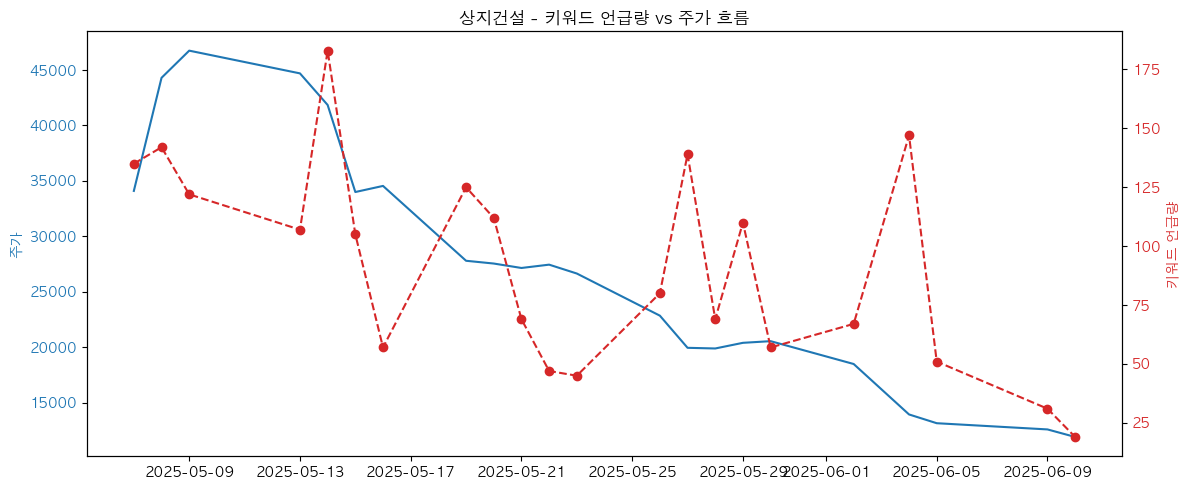

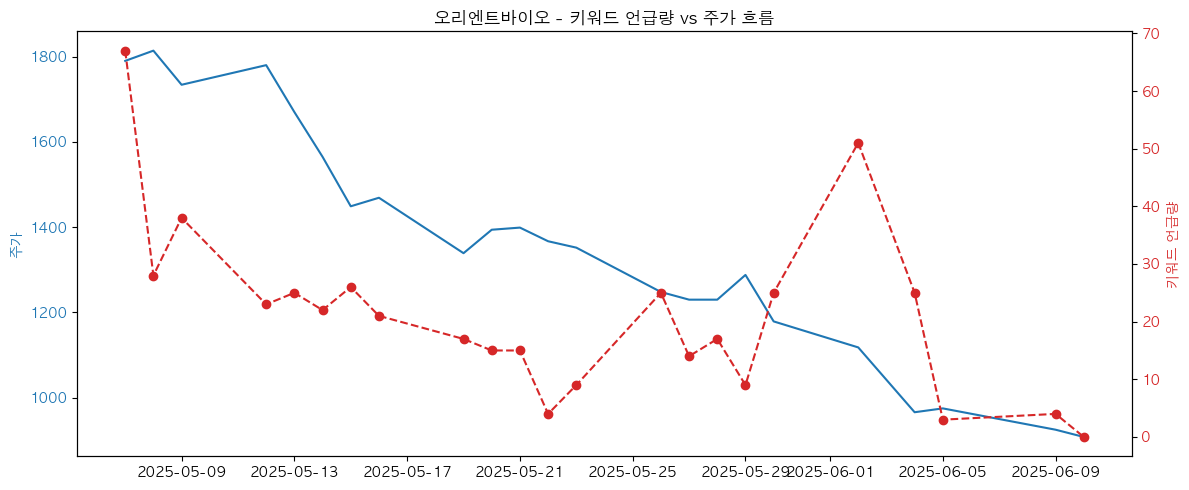

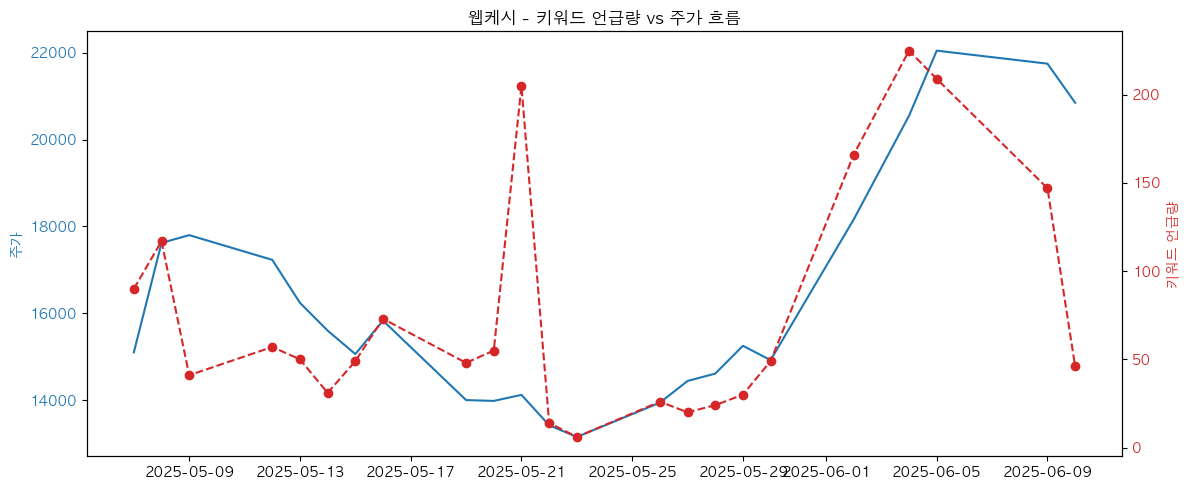

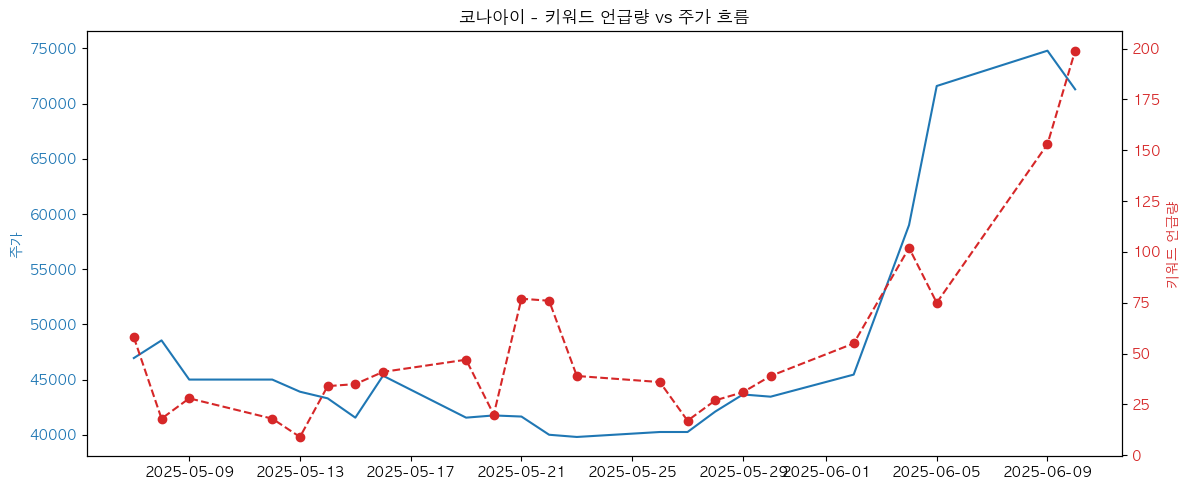

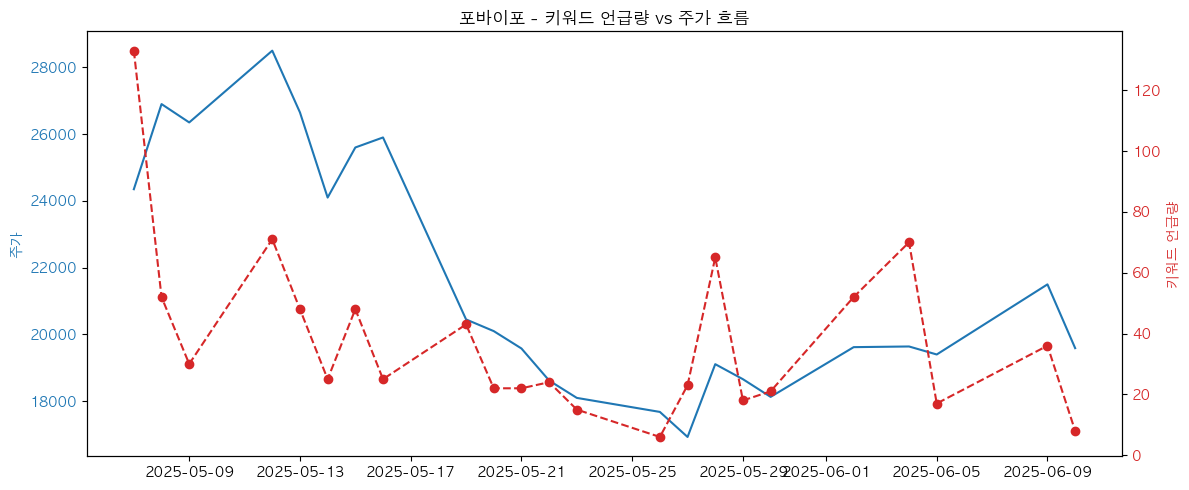

In [12]:
generator = BuzzChartGenerator(final_df, jae_df, DATA_DIR)

for stock in final_df["종목명"].unique():
    if stock not in jae_df["종목명"].values:
        continue
    buzz_df = generator.extract_keywords_by_date(
        stock, start_date=FIXED_START, end_date=FIXED_END
    )
    merged_df = generator.merge_with_price(
        stock, buzz_df, start_date=FIXED_START, end_date=FIXED_END
    )
    generator.plot_buzz_chart(merged_df, stock)

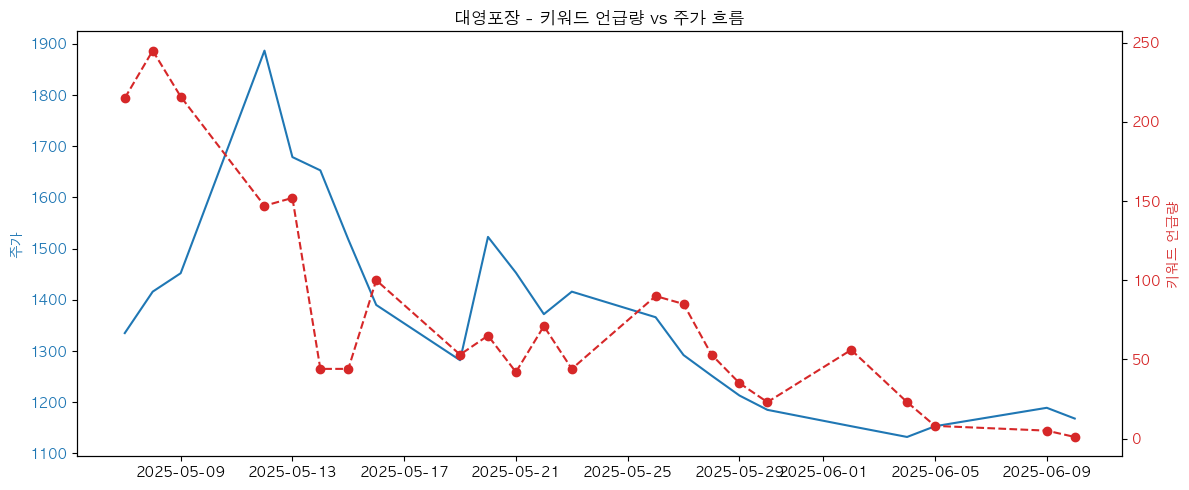

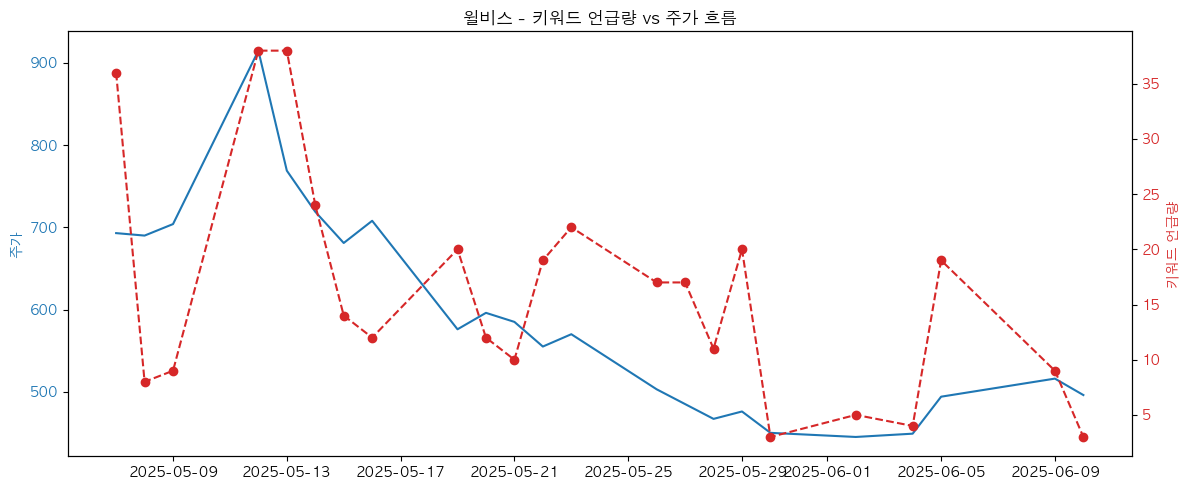

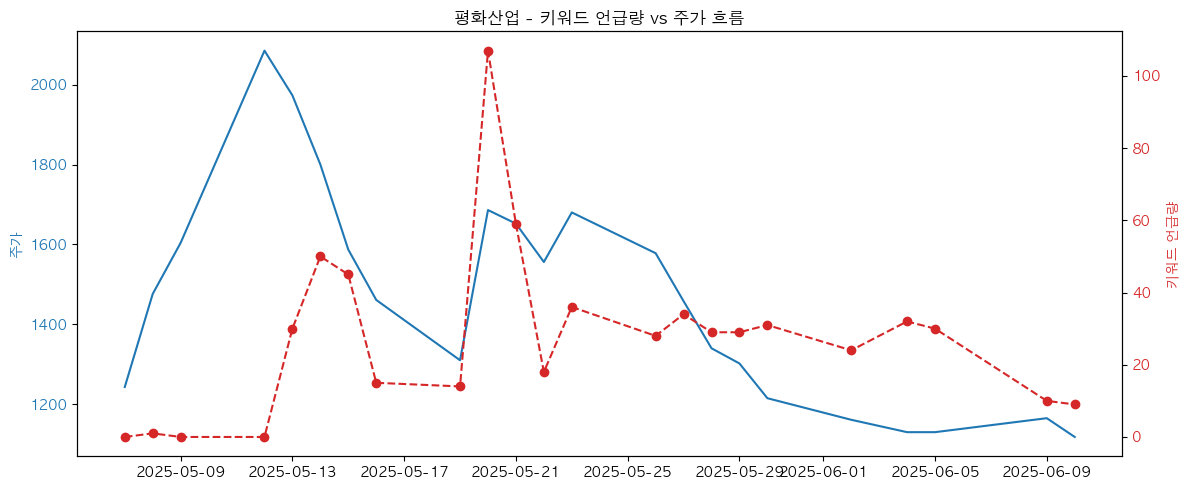

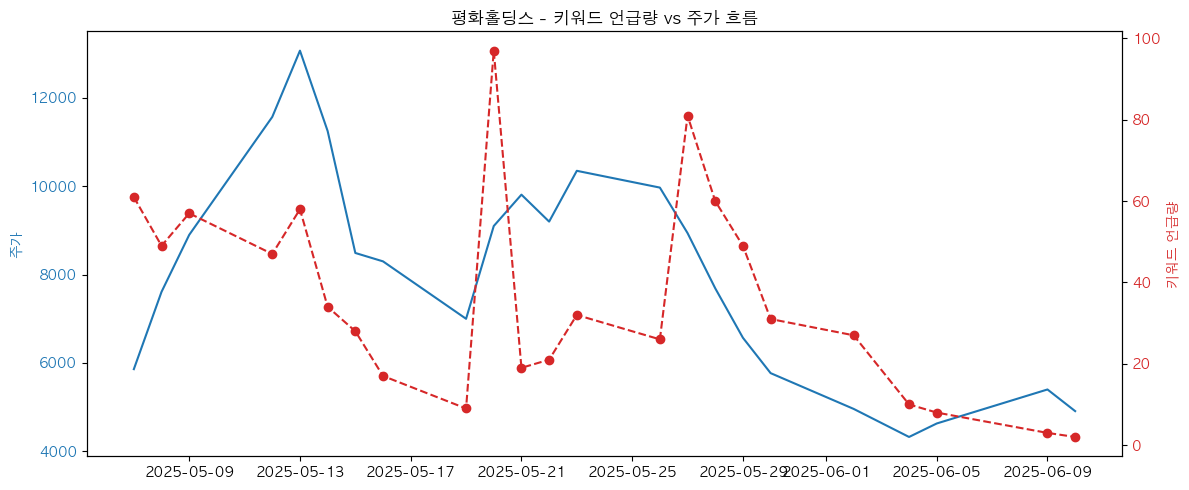

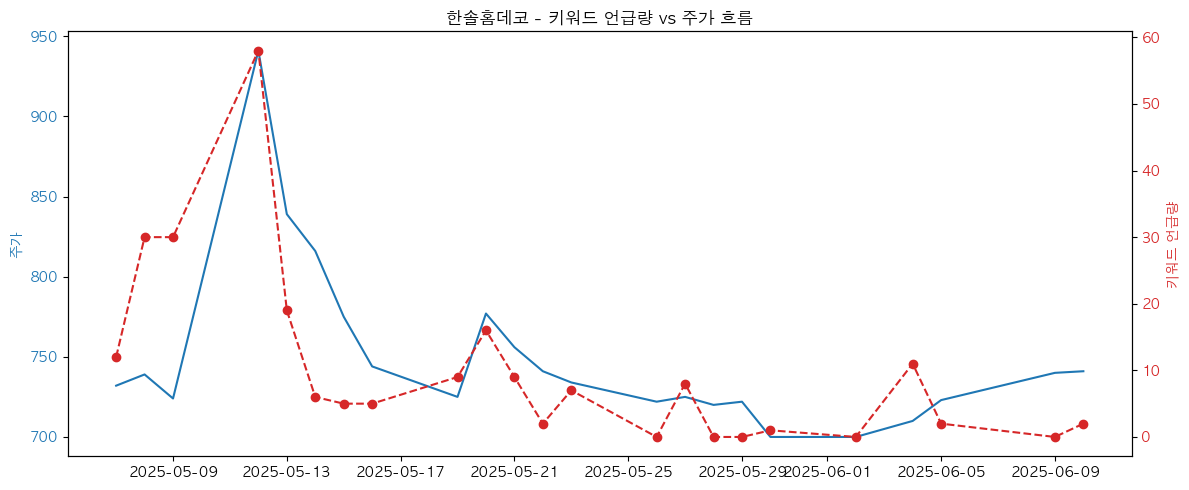

In [13]:
generator = BuzzChartGenerator(final_df, moon_df, DATA_DIR)

for stock in final_df["종목명"].unique():
    if stock not in moon_df["종목명"].values:
        continue
    buzz_df = generator.extract_keywords_by_date(
        stock, start_date=FIXED_START, end_date=FIXED_END
    )
    merged_df = generator.merge_with_price(
        stock, buzz_df, start_date=FIXED_START, end_date=FIXED_END
    )
    generator.plot_buzz_chart(merged_df, stock)

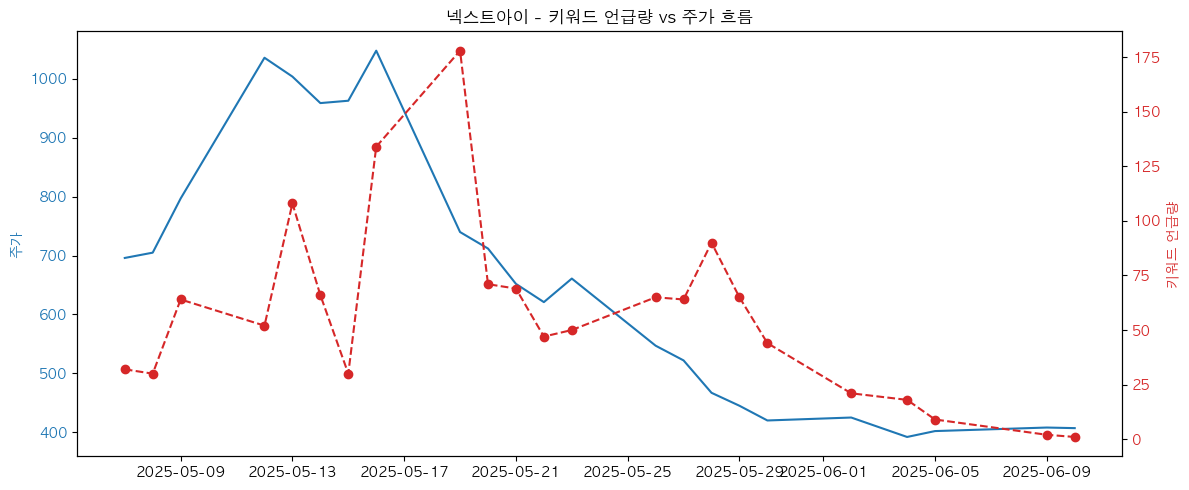

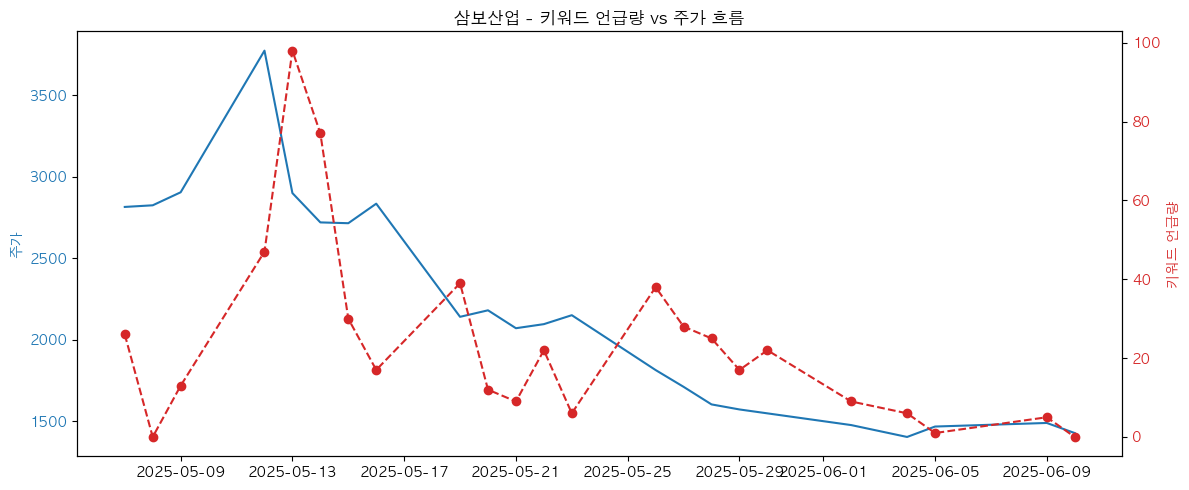

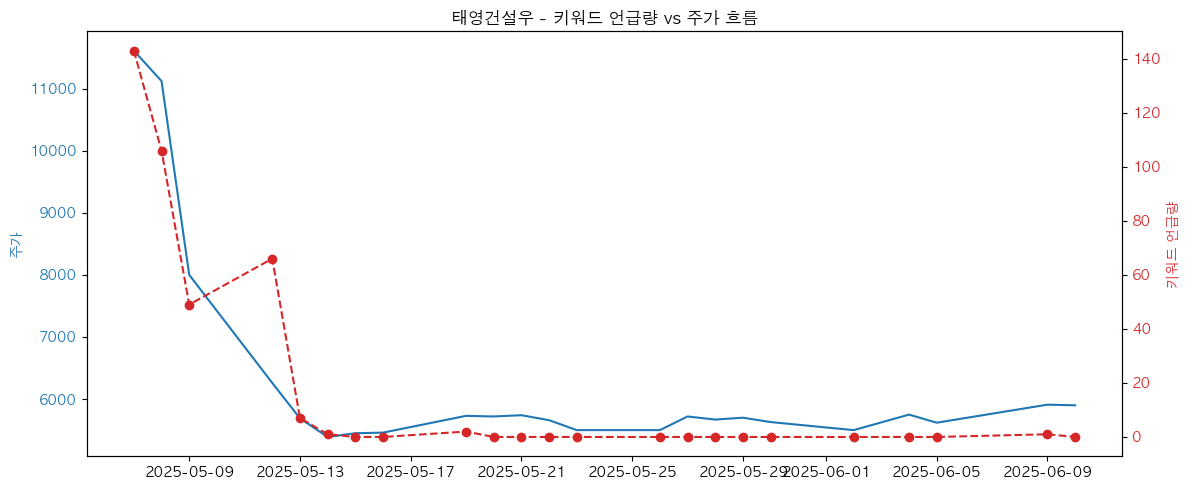

In [14]:
generator = BuzzChartGenerator(final_df, jun_df, DATA_DIR)

for stock in final_df["종목명"].unique():
    if stock not in jun_df["종목명"].values:
        continue
    buzz_df = generator.extract_keywords_by_date(
        stock, start_date=FIXED_START, end_date=FIXED_END
    )
    merged_df = generator.merge_with_price(
        stock, buzz_df, start_date=FIXED_START, end_date=FIXED_END
    )
    generator.plot_buzz_chart(merged_df, stock)